# Skorch

https://github.com/skorch-dev/skorch  
https://skorch.readthedocs.io/en/latest/?badge=latest

In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from sklearn.metrics import accuracy_score
from skorch import NeuralNet
from skorch.callbacks.scoring import EpochScoring
from torch import nn
from torch.nn import functional as F
from torch.optim import SGD

from utils.vis import plot_decision_space, visualize_data
from utils.metrics import calculate_acc


RANDOM_STATE = 45

np.random.seed(RANDOM_STATE)

%matplotlib inline

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(7)


# Prepare and Visualize data

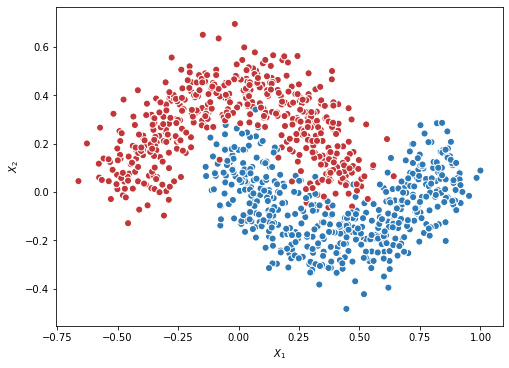

In [7]:
N_FEATURES = 2

X, Y = make_blobs(centers=2, random_state=RANDOM_STATE, n_features=N_FEATURES)
X, Y = make_moons(n_samples=1000, noise=0.2)
X = X/np.abs(X).max()
visualize_data(X,Y)

In [8]:

class Perceptron(nn.Module):
    def __init__(self, n_in):

        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(2, 10, bias=True)
        self.fc2 = nn.Linear(10, 10, bias=True)
        self.fc3 = nn.Linear(10, 10, bias=True)
        self.fc4 = nn.Linear(10, 10, bias=True)
        self.fc5 = nn.Linear(10, 1, bias=True)
        
    
    def forward(self, x):
        return self.fc5(self.fc4(self.fc3(F.relu(self.fc2(F.relu(self.fc1(x)))))))

  epoch     acc    train_loss    valid_loss     dur
-------  ------  ------------  ------------  ------
      1  0.8500        0.5083        0.3436  1.4407
      2  0.8650        0.3643        0.2901  1.7747
      3  0.8700        0.3434        0.2942  1.6048
      4  0.8950        0.3473        0.2799  1.4245
      5  0.9000        0.3250        0.2605  1.7306
      6  0.8800        0.3186        0.2565  1.4785
      7  0.8900        0.3087        0.2534  1.2396
      8  0.9200        0.2915        0.2269  1.3147
      9  0.9400        0.2788        0.1760  1.3041
     10  0.9500        0.2409        0.1927  1.4697


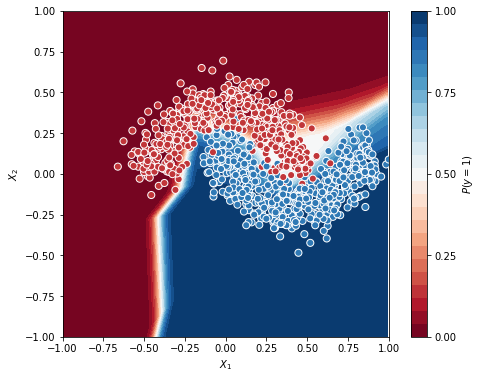

In [9]:
N_EPOCHS = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# init the model, loss and optimizer
net = Perceptron(2)
optimizer = SGD(net.parameters(), lr=0.1)
criterion = nn.BCEWithLogitsLoss()
net = net.to(DEVICE)

sigmoid = lambda x:  1. / (1. + np.exp(-x))

def acc(net, ds, y):
    predicted_logit_masks = sigmoid(net.predict(ds)) > 0.5
    return accuracy_score(y, predicted_logit_masks)

epoch_scoring = EpochScoring(scoring=acc, on_train=False)


net = Perceptron(2)

skorch_net = NeuralNet(net, 
                       criterion=nn.BCEWithLogitsLoss,
                       batch_size=1,
                       lr=0.1, 
                       callbacks=[epoch_scoring], 
                       device=DEVICE,
                       optimizer=SGD)


history = skorch_net.fit(X.astype('float32'), Y.reshape(-1, 1).astype('float32'), epochs=N_EPOCHS)
f = plot_decision_space(net, X, Y)
        

Text(0.5, 0, 'epochs')

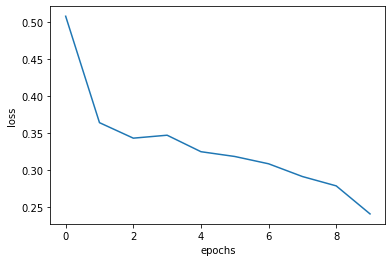

In [10]:
plt.plot([a['train_loss'] for a in history.history])
plt.ylabel('loss')
plt.xlabel('epochs')